In [1]:
# instalacja paczek, które przydadzą się później

#!pip install nfstream

In [2]:
# import potrzebnych bibliotek do środowiska programistycznego (zostaną wykorzystane później)

import nfstream
from nfstream import NFStreamer
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


## Pobranie i wczytanie danych do programu

In [3]:
# Pobranie próbek z logami z sieci (w normalnym wypadku bralibyśmy je najpewniej gdzieś z naszej sieci)
# !wget -O normal_traffic.pcap https://mcfp.felk.cvut.cz/publicDatasets/CTU-Normal-13/2017-07-03_capture-win2.pcap
# !wget -O malicious_traffic.pcap https://mcfp.felk.cvut.cz/publicDatasets/CTU-Malware-Capture-Botnet-14/2013-10-18_capture-win15.pcap


In [4]:
%tb
# Wczytanie ruchu normalnego
normal_streamer = NFStreamer(source="normal_traffic.pcap", statistical_analysis=True)
normal_flows = normal_streamer.to_pandas()
normal_flows['label'] = 0  # Oznaczenie ruchu jako normalnego

# Wczytanie ruchu złośliwego
malicious_streamer = NFStreamer(source="malicious_traffic.pcap", statistical_analysis=True)
malicious_flows = malicious_streamer.to_pandas()
malicious_flows['label'] = 1  # Oznaczenie ruchu jako złośliwego

# Połączenie obu zbiorów danych
data = pd.concat([normal_flows, malicious_flows], ignore_index=True)

# Wyświetlenie pierwszych rekordów zbiorów danych
data.head()


No traceback available to show.


,id,expiration_id,src_ip,src_mac,src_oui,src_port,dst_ip,dst_mac,dst_oui,dst_port,...,application_name,application_category_name,application_is_guessed,application_confidence,requested_server_name,client_fingerprint,server_fingerprint,user_agent,content_type,label
0,0,0,192.168.1.112,08:00:27:e1:e3:8a,08:00:27,54926,8.8.8.8,1c:6f:65:c0:43:92,1c:6f:65,53,...,DNS.Microsoft,Network,0,6,www.msftncsi.com,NaN,NaN,NaN,NaN,0
1,1,0,192.168.1.112,08:00:27:e1:e3:8a,08:00:27,62576,8.8.8.8,1c:6f:65:c0:43:92,1c:6f:65,53,...,DNS.Microsoft,Network,0,6,www.msftncsi.com,NaN,NaN,NaN,NaN,0
2,2,0,fd2d:ab8c:225:0:79ec:26b9:bb98:fae8,08:00:27:e1:e3:8a,08:00:27,60970,fd2d:ab8c:225::1,d8:58:d7:00:0f:72,d8:58:d7,53,...,DNS.Microsoft,Network,0,6,dns.msftncsi.com,NaN,NaN,NaN,NaN,0
3,3,0,192.168.1.112,08:00:27:e1:e3:8a,08:00:27,49159,2.16.4.152,1c:6f:65:c0:43:92,1c:6f:65,80,...,HTTP,Web,1,1,NaN,NaN,NaN,NaN,NaN,0
4,4,0,fe80::da58:d7ff:fe00:f72,d8:58:d7:00:0f:72,d8:58:d7,0,fd2d:ab8c:225:0:79ec:26b9:bb98:fae8,08:00:27:e1:e3:8a,08:00:27,0,...,ICMPV6,Network,0,6,NaN,NaN,NaN,NaN,NaN,0


## Eksploracja i czyszczenie danych

In [5]:
# Wyświetlenie podstawowych informacji o zbiorach danych
data.info()

# Usuwanie kolumn, które mają tylko jedną unikalną wartość lub brakujące wartości
for col in data.columns:
    if data[col].nunique() == 1 or data[col].isnull().any():
        data.drop(col, inplace=True, axis=1)

# Wyświetlenie liczby rekordów po czyszczeniu
print(f"Liczba rekordów po czyszczeniu: {data.shape[0]}")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450 entries, 0 to 449
Data columns (total 87 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            450 non-null    int64  
 1   expiration_id                 450 non-null    int64  
 2   src_ip                        450 non-null    object 
 3   src_mac                       450 non-null    object 
 4   src_oui                       450 non-null    object 
 5   src_port                      450 non-null    int64  
 6   dst_ip                        450 non-null    object 
 7   dst_mac                       450 non-null    object 
 8   dst_oui                       450 non-null    object 
 9   dst_port                      450 non-null    int64  
 10  protocol                      450 non-null    int64  
 11  ip_version                    450 non-null    int64  
 12  vlan_id                       450 non-null    int64  
 13  tunne

In [6]:
# Eksperymenty - eksploracja szczegółowa

# Wyświetlenie unikalnych wartości w kolumnach (można wybrać kolumnę do analizy)
column_name = 'src_ip'  # Przykład nazwy kolumny
print("Unikalne wartości w kolumnie:", column_name)
print(data[column_name].unique())

# Eksploracja liczby rekordów dla każdej etykiety
print("Liczba rekordów dla każdej etykiety:")
print(data['label'].value_counts())

# Histogramy dla wybranych cech numerycznych (należy odkomentować i zmodyfikować)
# data['some_numeric_column'].hist(bins=30)
# plt.title('Histogram cechy some_numeric_column')
# plt.show()


Unikalne wartości w kolumnie: src_ip
['192.168.1.112' 'fd2d:ab8c:225:0:79ec:26b9:bb98:fae8'
 'fe80::da58:d7ff:fe00:f72' 'fd2d:ab8c:225::1' 'fe80::a866:72ce:9643:c9b1'
 '10.0.2.115' '::' '10.0.2.2']
Liczba rekordów dla każdej etykiety:
label
1    403
0     47
Name: count, dtype: int64


## Analiza korelacji cech

10 cech najbardziej skorelowanych z etykietą:
 bidirectional_min_ps          0.813236
src2dst_min_ps                0.812468
src_port                     -0.810491
bidirectional_min_piat_ms     0.794612
dst2src_first_seen_ms        -0.759012
bidirectional_mean_piat_ms    0.734732
dst2src_mean_ps              -0.731854
dst2src_max_ps               -0.717738
dst2src_last_seen_ms         -0.702513
bidirectional_stddev_ps      -0.694309
Name: label, dtype: float64


/tmp/ipykernel_26383/2078466250.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10_correlated_features.index, y=top_10_correlated_features.values, palette='viridis')


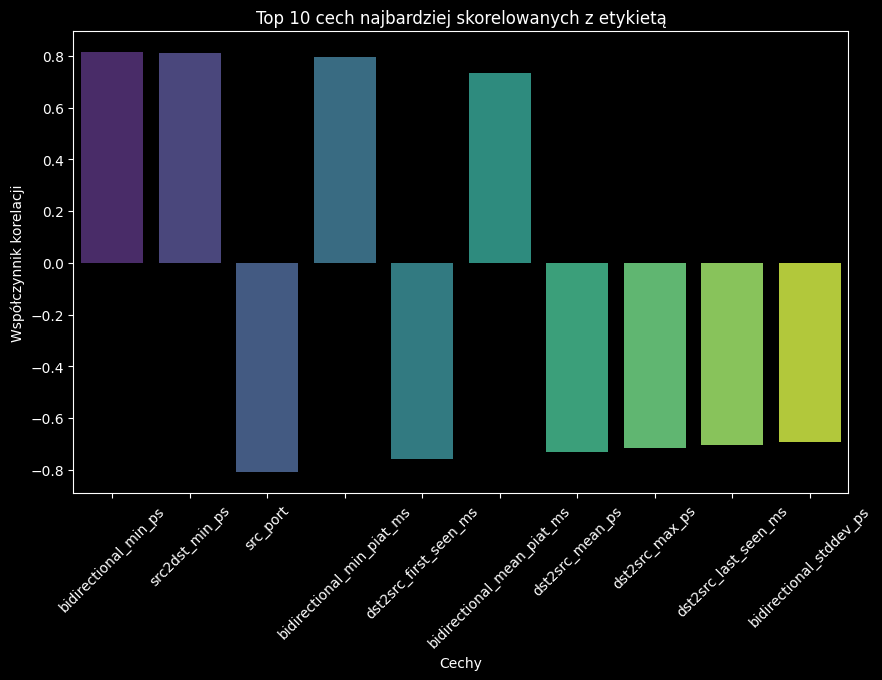

In [7]:
import seaborn as sns

# Wybranie tylko kolumn numerycznych (int i float)
data = data.select_dtypes(include=[np.number])

# Sprawdzenie, czy kolumna 'label' istnieje w danych
if 'label' in data.columns:
    # Obliczanie korelacji wszystkich cech z etykietą
    correlation_with_label = data.corr()['label'].sort_values(key=abs, ascending=False)

    # Usunięcie korelacji etykiety z samą sobą
    correlation_with_label = correlation_with_label.drop('label', errors='ignore')

    # Wybór 10 najbardziej skorelowanych cech
    top_10_correlated_features = correlation_with_label.head(10)

    print("10 cech najbardziej skorelowanych z etykietą:\n", top_10_correlated_features)

    # Wizualizacja korelacji tych cech z etykietą
    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_10_correlated_features.index, y=top_10_correlated_features.values, palette='viridis')
    plt.title('Top 10 cech najbardziej skorelowanych z etykietą')
    plt.xlabel('Cechy')
    plt.ylabel('Współczynnik korelacji')
    plt.xticks(rotation=45)  # Obrót etykiet osi X dla lepszej czytelności
    plt.show()
else:
    print("Brak kolumny 'label' w danych.")


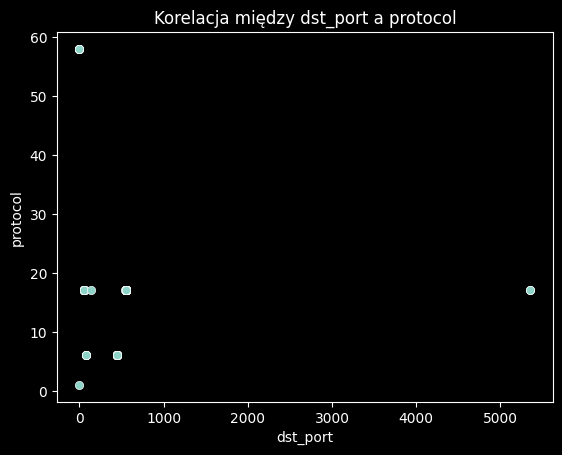

In [18]:
# Eksperymenty - analiza wybranych korelacji

# Wybór korelacji do szczegółowej analizy (należy odkomentować i zmodyfikować)
feature1 = 'dst_port'
feature2 = 'protocol'
sns.scatterplot(x=data[feature1], y=data[feature2])
plt.title(f'Korelacja między {feature1} a {feature2}')
plt.show()


## Przygotowanie danych do modelowania

In [9]:
X = data.drop('label', axis=1)
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


## Budowanie i trenowanie modelu

In [10]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

def train_and_evaluate_decision_tree(X_train, y_train, X_test, y_test, max_depth=None, criterion='gini'):
    # Trenowanie modelu Decision Tree z określonymi parametrami
    tree_model = DecisionTreeClassifier(max_depth=max_depth, criterion=criterion, random_state=42)
    tree_model.fit(X_train, y_train)

    # Przewidywanie na zestawie testowym
    predictions = tree_model.predict(X_test)

    # Obliczenie metryk
    accuracy = accuracy_score(y_test, predictions)
    conf_matrix = confusion_matrix(y_test, predictions)

    # Wizualizacja drzewa
    plt.figure(figsize=(20,10))
    plot_tree(tree_model, filled=True, feature_names=X_train.columns, class_names=['Normal', 'Malicious'], fontsize=10)
    plt.title("Wizualizacja drzewa decyzyjnego")
    plt.show()

    return tree_model, accuracy, conf_matrix


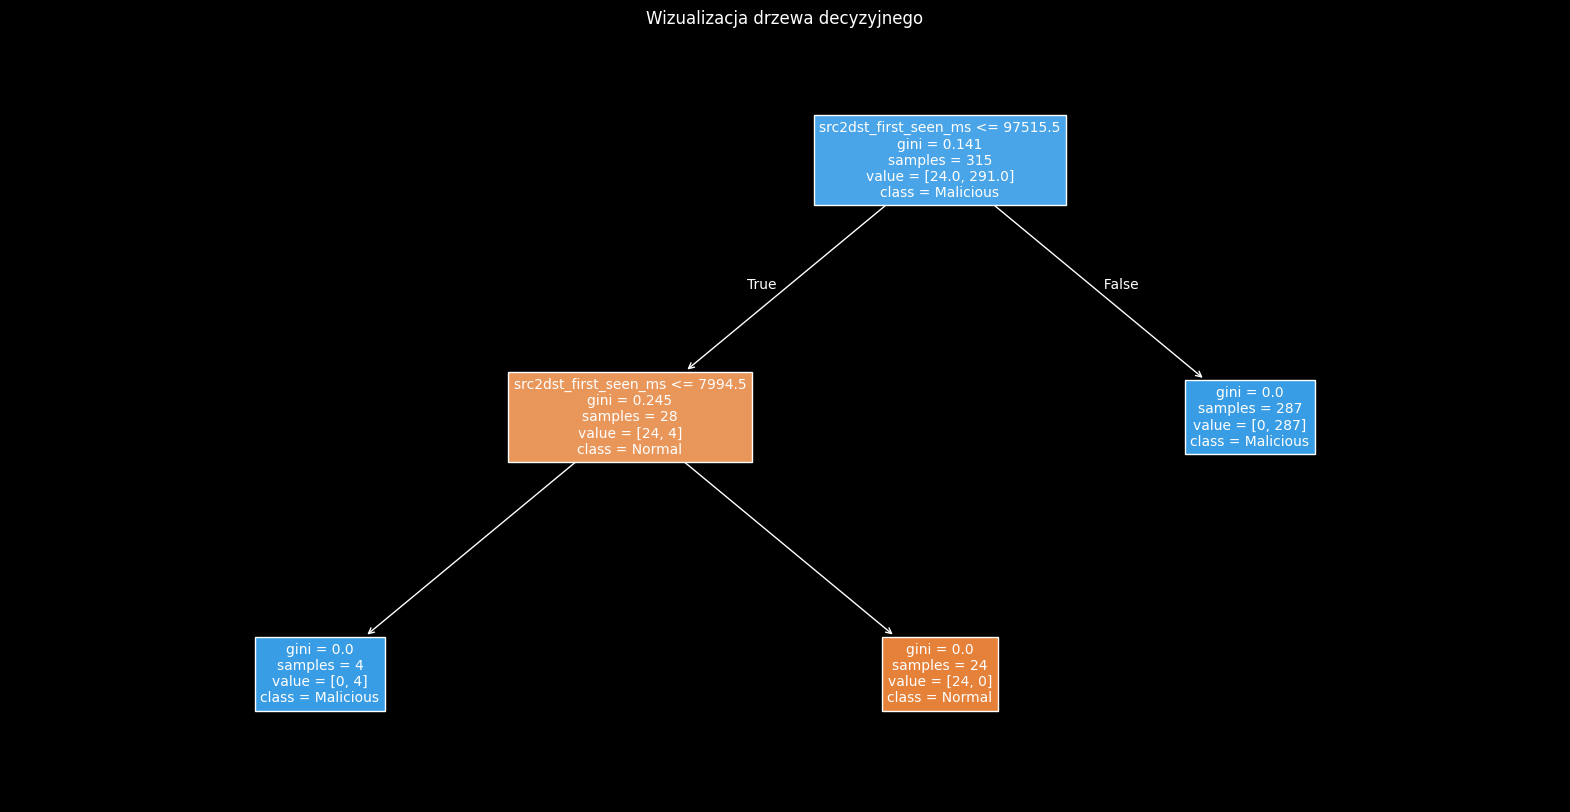

Dokładność modelu z domyślnymi parametrami: 0.9777777777777777


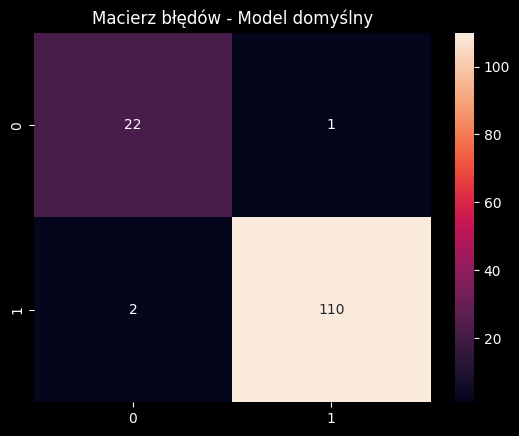

In [11]:
# Trenowanie i ocena modelu z domyślnymi parametrami
default_model, default_accuracy, default_conf_matrix = train_and_evaluate_decision_tree(X_train, y_train, X_test, y_test)

print("Dokładność modelu z domyślnymi parametrami:", default_accuracy)
sns.heatmap(default_conf_matrix, annot=True, fmt="d")
plt.title("Macierz błędów - Model domyślny")
plt.show()


## Interaktywne testowanie parametrów modelu

In [12]:
from ipywidgets import interactive

def interactive_decision_tree_testing(max_depth, criterion):
    _, new_accuracy, new_conf_matrix = train_and_evaluate_decision_tree(X_train, y_train, X_test, y_test, max_depth, criterion)

    print("Dokładność modelu na nowym zestawie danych:", new_accuracy)
    sns.heatmap(new_conf_matrix, annot=True, fmt="d", cmap='viridis')
    plt.title("Macierz błędów na nowym zestawie danych")
    plt.show()

# Stworzenie interaktywnego widgetu do eksperymentowania z parametrami
interactive_plot = interactive(interactive_decision_tree_testing,
                               max_depth=(1, 20, 1),
                               criterion=["gini", "entropy"])
interactive_plot


interactive(children=(IntSlider(value=10, description='max_depth', max=20, min=1), Dropdown(description='crite…

**Zadanie:** spróbuj z innymi zbiorami danych, np. spośród tych https://mcfp.felk.cvut.cz/publicDatasets/ (uwaga na rozmiary zbiorów, dla dużych objętności będzie to trwało bardzo długo). W tym celu najlepiej przerabiać kod powyżej, albo przeklejać komórki na nowo poniżej i edytować je w tym miejscu.

In [ ]:
!curl -O -L https://mcfp.felk.cvut.cz/publicDatasets/CTU-Malware-Capture-Botnet-91/capture.botnet2.infected.1.pcap
!curl -O -L https://mcfp.felk.cvut.cz/publicDatasets/CTU-Normal-28/2017-05-01_normal.pcap

In [13]:
normal2_streamer = NFStreamer(source="2017-05-01_normal.pcap", statistical_analysis=True)
normal2_flows = normal2_streamer.to_pandas()
normal2_flows['label'] = 0  # Oznaczenie ruchu jako normalnego

# Wczytanie ruchu złośliwego
botnet_streamer = NFStreamer(source="capture.botnet2.infected.1.pcap", statistical_analysis=True)
botnet_flows = botnet_streamer.to_pandas()
botnet_flows['label'] = 1  # Oznaczenie ruchu jako złośliwego

# Połączenie obu zbiorów danych
data2 = pd.concat([normal2_flows, botnet_flows], ignore_index=True)

# Wyświetlenie pierwszych rekordów zbiorów danych
data2.head()

/home/opliko/KRYCY2/.venv/lib/python3.10/site-packages/nfstream/streamer.py:547: DtypeWarning: Columns (82) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(temp_file_path)


,id,expiration_id,src_ip,src_mac,src_oui,src_port,dst_ip,dst_mac,dst_oui,dst_port,...,application_name,application_category_name,application_is_guessed,application_confidence,requested_server_name,client_fingerprint,server_fingerprint,user_agent,content_type,label
0,0,0,10.0.2.2,52:54:00:12:35:02,52:54:00,67,10.0.2.15,08:00:27:a3:83:43,08:00:27,68,...,DHCP,Network,0,6,NaN,NaN,NaN,NaN,NaN,0
1,1,0,0.0.0.0,08:00:27:a3:83:43,08:00:27,68,255.255.255.255,ff:ff:ff:ff:ff:ff,ff:ff:ff,67,...,DHCP,Network,0,6,tiny71,"1,15,3,6,44,46,47,31,33,121,249,43",NaN,NaN,NaN,0
2,2,0,fe80::69dd:e614:2b2:dfd0,08:00:27:a3:83:43,08:00:27,0,ff02::16,33:33:00:00:00:16,33:33:00,0,...,ICMPV6,Network,0,6,NaN,NaN,NaN,NaN,NaN,0
3,3,0,10.0.2.15,08:00:27:a3:83:43,08:00:27,56943,192.168.33.254,52:54:00:12:35:02,52:54:00,53,...,DNS.Cybersec,Network,0,6,updatekeepalive.mcafee.com,NaN,NaN,NaN,NaN,0
4,4,0,10.0.2.15,08:00:27:a3:83:43,08:00:27,50315,192.168.33.254,52:54:00:12:35:02,52:54:00,53,...,DNS.Cybersec,Network,0,6,updatekeepalive.mcafee.com,NaN,NaN,NaN,NaN,0


In [14]:
for col in data2.columns:
    if data2[col].nunique() == 1 or data2[col].isnull().any():
        data2.drop(col, inplace=True, axis=1)
data2 = data2.select_dtypes(include=[np.number])


In [15]:
X2 = data2.drop('label', axis=1)
y2 = data2['label']
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.3, random_state=42)

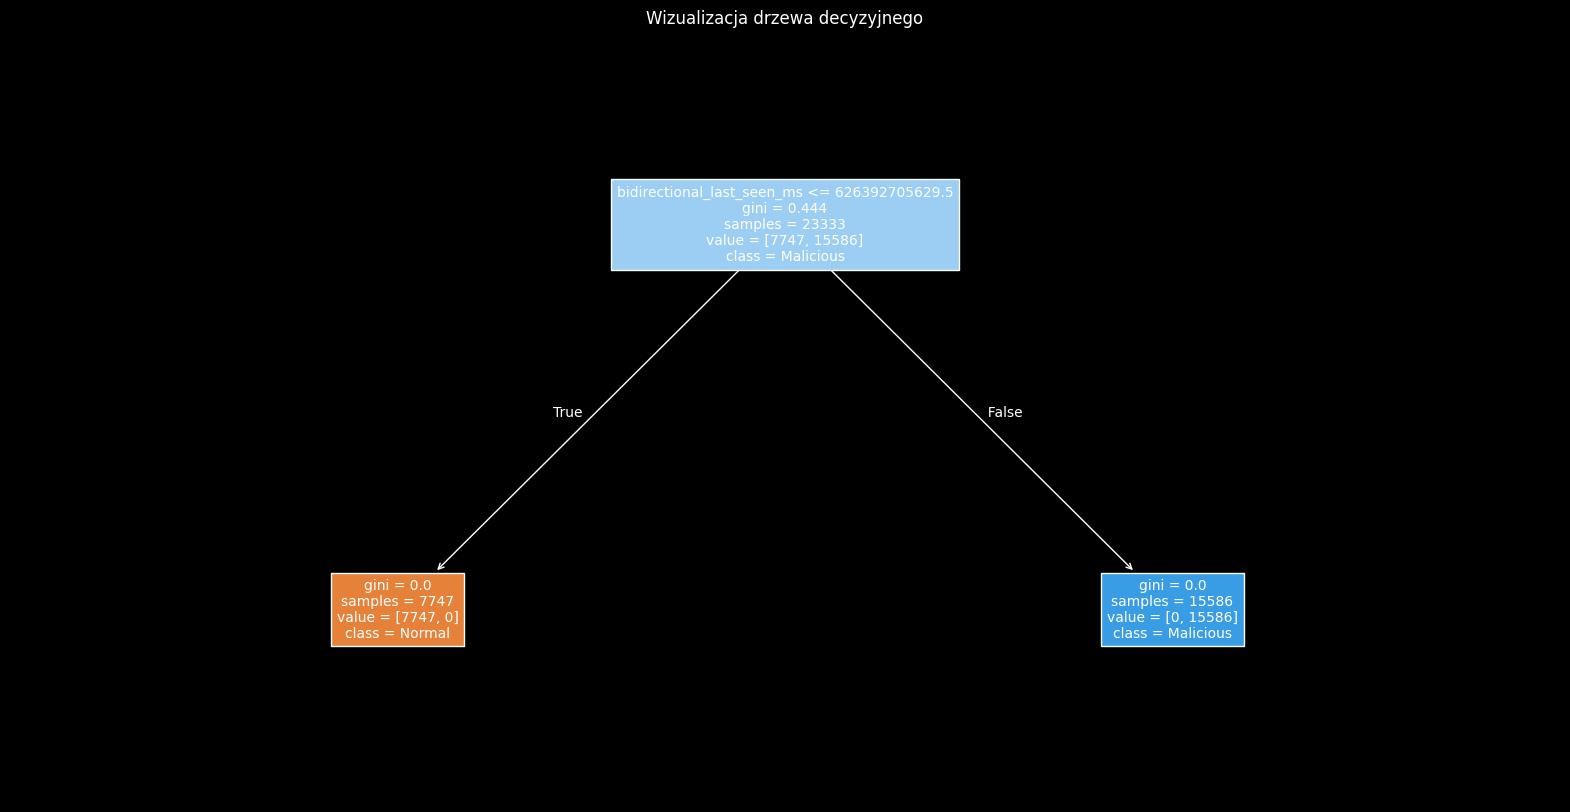

In [16]:
default_model2, default_accuracy2, default_conf_matrix2 = train_and_evaluate_decision_tree(X2_train, y2_train, X2_test, y2_test)


In [17]:
def interactive_decision_tree_testing2(max_depth, criterion):
    _, new_accuracy, new_conf_matrix = train_and_evaluate_decision_tree(X2_train, y2_train, X2_test, y2_test, max_depth, criterion)

    print("Dokładność modelu na nowym zestawie danych:", new_accuracy)
    sns.heatmap(new_conf_matrix, annot=True, fmt="d", cmap='viridis')
    plt.title("Macierz błędów na nowym zestawie danych")
    plt.show()

# Stworzenie interaktywnego widgetu do eksperymentowania z parametrami
interactive_plot = interactive(interactive_decision_tree_testing2,
                               max_depth=(1, 20, 1),
                               criterion=["gini", "entropy"])
interactive_plot

interactive(children=(IntSlider(value=10, description='max_depth', max=20, min=1), Dropdown(description='crite…